# Polymer Representation Analysis Resources

https://zoehlerbz.medium.com/molecule-clustering-using-the-butina-algorithm-application-with-python-and-rdkit-ffb5b5721447

https://github.com/zoehlerbz/rdkit_basico

https://www.osti.gov/pages/servlets/purl/2328569

https://github.com/PatWalters/practical_cheminformatics_tutorials?tab=readme-ov-file

https://drzinph.com/maccs-fingerprints-in-python-part-2/

https://www.rdkit.org/docs/source/rdkit.ML.Cluster.Murtagh.html

https://github.com/argonne-lcf/molan/tree/master/code/melting_predict_Spark_RF



In [41]:
# Install required packages
%pip install rdkit umap-learn tqdm scikit-learn pandas numpy matplotlib plotly transformers accelerate torch

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [42]:
import os
# Force transformers to use PyTorch only (avoid TensorFlow import issues)
os.environ['TRANSFORMERS_NO_TF'] = '1'
os.environ['USE_TF'] = '0'

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, MACCSkeys, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score,
    accuracy_score, f1_score, classification_report
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import torch
from transformers import AutoTokenizer, AutoModel

print("All imports successful!")

All imports successful!


## 1. Load and Clean Dataset
### 1.1 Load Data

In [43]:
import pandas as pd
RAW_URL = "https://raw.githubusercontent.com/Syedomershah99/AI-for-Polymer-Representation/main/PI1070.csv"
df_raw = pd.read_csv(RAW_URL, engine="c", low_memory=False)
print(df_raw.shape)
df_raw = pd.read_csv(RAW_URL)
print(f"Loaded dataset: {df_raw.shape}")
print(f"Columns: {df_raw.columns[:15].tolist()}...")
df_raw.head(3)

(1077, 157)
Loaded dataset: (1077, 157)
Columns: ['monomer_ID', 'smiles', 'mol_weight_monomer', 'atomic_weight_mean', 'vdw_volume_monomer', 'qm_total_energy_monomer', 'qm_homo_monomer', 'qm_lumo_monomer', 'qm_dipole_monomer', 'qm_dipole_x_monomer', 'qm_dipole_y_monomer', 'qm_dipole_z_monomer', 'qm_polarizability_monomer', 'qm_polarizability_xx_monomer', 'qm_polarizability_yy_monomer']...


,monomer_ID,smiles,mol_weight_monomer,atomic_weight_mean,vdw_volume_monomer,qm_total_energy_monomer,qm_homo_monomer,qm_lumo_monomer,qm_dipole_monomer,qm_dipole_x_monomer,...,TC_improper_min,TC_improper_max,TC_improper_std,TC_improper_count,TC_kspace,TC_kspace_min,TC_kspace_max,TC_kspace_std,TC_kspace_count,polymer_class
0,PI1,*CC*,28.054,4.675667,45.008,-209676.7175,-12.037272,3.128817,0.000009,0.000006,...,0.0,0.0,0.0,5.0,0.000014,-0.000028,0.000029,0.000024,5.0,1
1,PI2,*C(C*)C,42.081,4.675667,61.624,-312948.9242,-11.576865,3.039961,0.077278,0.003980,...,0.0,0.0,0.0,5.0,0.000279,-0.000165,0.000562,0.000302,5.0,1
2,PI3,*C(C*)CC,56.108,4.675667,78.424,-416219.2389,-11.423908,2.987135,0.081852,-0.003192,...,0.0,0.0,0.0,5.0,0.000059,-0.000043,0.000288,0.000133,5.0,1


### 1.2 Canonicalize SMILES and Clean Dataset

In [44]:
def canonicalize_smiles(smiles):
    """
    Canonicalize SMILES string using RDKit.
    Returns canonical SMILES or None if invalid.
    """
    try:
        smiles = str(smiles).strip()
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return Chem.MolToSmiles(mol, canonical=True)
    except Exception:
        return None

def clean_dataset(df):
    """
    Clean the dataset:
    1. Canonicalize SMILES
    2. Remove invalid entries
    3. Deduplicate based on canonical SMILES
    """
    df = df.copy()
    
    # Step 1: Canonicalize SMILES
    print("Canonicalizing SMILES...")
    tqdm.pandas(desc="Canonicalizing")
    df['smiles_canonical'] = df['smiles'].progress_apply(canonicalize_smiles)
    
    # Step 2: Remove invalid SMILES
    n_before = len(df)
    df = df[df['smiles_canonical'].notna()].reset_index(drop=True)
    n_invalid = n_before - len(df)
    print(f"Removed {n_invalid} invalid SMILES entries")
    
    # Step 3: Deduplicate based on canonical SMILES
    n_before = len(df)
    df = df.drop_duplicates(subset='smiles_canonical', keep='first').reset_index(drop=True)
    n_duplicates = n_before - len(df)
    print(f"Removed {n_duplicates} duplicate SMILES entries")
    
    # Create mol objects
    df['mol'] = df['smiles_canonical'].apply(lambda s: Chem.MolFromSmiles(s))
    
    print(f"Final dataset size: {len(df)}")
    return df

df = clean_dataset(df_raw)
print(f"\nDataset summary:")
print(f"  - Total polymers: {len(df)}")
print(f"  - Has polymer_class: {'polymer_class' in df.columns}")
if 'polymer_class' in df.columns:
    print(f"  - Unique classes: {df['polymer_class'].nunique()}")
    print(f"  - Class distribution:\n{df['polymer_class'].value_counts()}")

Canonicalizing SMILES...


Canonicalizing:   0%|          | 0/1077 [00:00<?, ?it/s]

Removed 0 invalid SMILES entries
Removed 0 duplicate SMILES entries
Final dataset size: 1077

Dataset summary:
  - Total polymers: 1077
  - Has polymer_class: True
  - Unique classes: 20
  - Class distribution:
polymer_class
13    261
3     162
2     161
4     118
1      83
7      67
9      67
10     50
15     40
16     11
11     11
8      11
6       9
5       8
21      6
12      5
20      4
14      1
18      1
19      1
Name: count, dtype: int64


## 2. Compute Polymer Representations

We compute four types of representations:
1. **Morgan Fingerprints** (ECFP) - circular fingerprints capturing local atom environments
2. **MACCS Keys** - 166 predefined structural keys (standard substructure patterns)
3. **RDKit Descriptors + MACCS Motifs** - physicochemical descriptors with substructure information
4. **Transformer Embeddings** - pretrained polyBERT embeddings

### 2.1 Morgan Fingerprints (ECFP)

In [45]:
def compute_morgan_fingerprints(mols, radius=2, n_bits=2048):
    """
    Compute Morgan fingerprints (ECFP) for a list of molecules.
    Returns both RDKit bitvectors and numpy arrays.
    """
    fps_rdkit = []  # For Tanimoto calculations
    fps_array = []  # For ML models
    
    for mol in tqdm(mols, desc="Computing Morgan FPs"):
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        fps_rdkit.append(fp)
        
        arr = np.zeros((n_bits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps_array.append(arr)
    
    return fps_rdkit, np.vstack(fps_array)

fps_morgan_rdkit, X_morgan = compute_morgan_fingerprints(df['mol'].tolist())
print(f"Morgan fingerprints shape: {X_morgan.shape}")
print(f"Sparsity: {100 * (X_morgan == 0).sum() / X_morgan.size:.1f}%")

Computing Morgan FPs:   0%|          | 0/1077 [00:00<?, ?it/s]

Morgan fingerprints shape: (1077, 2048)
Sparsity: 98.5%


### 2.2 MACCS Keys (166 Standard Substructure Patterns)

In [46]:
def compute_maccs_keys(mols):
    """
    Compute MACCS keys (166-bit structural keys) for molecules.
    MACCS keys are standard substructure patterns widely used in cheminformatics.
    """
    fps_rdkit = []
    fps_array = []
    
    for mol in tqdm(mols, desc="Computing MACCS keys"):
        fp = MACCSkeys.GenMACCSKeys(mol)
        fps_rdkit.append(fp)
        
        arr = np.zeros((167,), dtype=np.int8)  # MACCS has 167 bits (0-166)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps_array.append(arr)
    
    return fps_rdkit, np.vstack(fps_array)

fps_maccs_rdkit, X_maccs = compute_maccs_keys(df['mol'].tolist())
print(f"MACCS keys shape: {X_maccs.shape}")
print(f"Active bits per molecule (mean): {X_maccs.sum(axis=1).mean():.1f}")

Computing MACCS keys:   0%|          | 0/1077 [00:00<?, ?it/s]

MACCS keys shape: (1077, 167)
Active bits per molecule (mean): 27.2


### 2.3 RDKit Descriptors + MACCS Motifs

In [47]:
def compute_rdkit_descriptors(mols):
    """
    Compute all RDKit molecular descriptors.
    Handles NaN/Inf values by imputing with column medians.
    """
    # Use only first 185 descriptors to match trained models (avoid version mismatch)
    descriptor_names = [d[0] for d in Descriptors._descList[:161]]
    descriptor_fns = [d[1] for d in Descriptors._descList[:161]]
    
    results = []
    for mol in tqdm(mols, desc="Computing RDKit descriptors"):
        vals = []
        for fn in descriptor_fns:
            try:
                v = fn(mol)
                if v is None or (isinstance(v, float) and (np.isnan(v) or np.isinf(v))):
                    v = np.nan
            except Exception:
                v = np.nan
            vals.append(v)
        results.append(vals)
    
    X = np.array(results, dtype=np.float32)
    
    # Remove columns that are all NaN
    valid_mask = ~np.all(np.isnan(X), axis=0)
    X = X[:, valid_mask]
    kept_names = [n for n, keep in zip(descriptor_names, valid_mask) if keep]
    
    # Impute remaining NaNs with column medians
    col_median = np.nanmedian(X, axis=0)
    nan_idx = np.where(np.isnan(X))
    X[nan_idx] = np.take(col_median, nan_idx[1])
    
    return X, kept_names

X_rdkit_desc, rdkit_desc_names = compute_rdkit_descriptors(df['mol'].tolist())
print(f"RDKit descriptors shape: {X_rdkit_desc.shape}")

# Combine RDKit descriptors with MACCS keys as motif representation
X_desc_maccs = np.hstack([X_rdkit_desc, X_maccs.astype(np.float32)])
print(f"RDKit + MACCS combined shape: {X_desc_maccs.shape}")

Computing RDKit descriptors:   0%|          | 0/1077 [00:00<?, ?it/s]

RDKit descriptors shape: (1077, 209)
RDKit + MACCS combined shape: (1077, 376)


### 2.4 Transformer Embeddings (polyBERT)

In [48]:
import os
# Force transformers to use PyTorch only (avoid TensorFlow import issues)
os.environ['TRANSFORMERS_NO_TF'] = '1'
os.environ['USE_TF'] = '0'

def compute_transformer_embeddings(smiles_list, model_name="kuelumbus/polyBERT", 
                                    batch_size=64, max_len=256, pooling="cls"):
    """
    Compute transformer embeddings using a pretrained SMILES encoder.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()
    
    embeddings = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(smiles_list), batch_size), desc="Computing embeddings"):
            batch = smiles_list[i:i+batch_size]
            
            tokens = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            ).to(device)
            
            output = model(**tokens)
            hidden = output.last_hidden_state
            
            if pooling == "cls":
                emb = hidden[:, 0, :]
            else:  # mean pooling
                mask = tokens["attention_mask"].unsqueeze(-1)
                emb = (hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
            
            embeddings.append(emb.cpu().numpy())
    
    return np.vstack(embeddings)

X_transformer = compute_transformer_embeddings(df['smiles_canonical'].tolist())
print(f"Transformer embeddings shape: {X_transformer.shape}")

Using device: cpu


TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

### 2.5 Standardize Representations

In [ ]:
# Create output directories if they don't exist
import os
os.makedirs('plots', exist_ok=True)
os.makedirs('representations', exist_ok=True)

# Standardize continuous representations (not binary fingerprints)
scaler_rdkit = StandardScaler()
X_rdkit_desc_scaled = scaler_rdkit.fit_transform(X_rdkit_desc)

scaler_desc_maccs = StandardScaler()
X_desc_maccs_scaled = scaler_desc_maccs.fit_transform(X_desc_maccs)

scaler_transformer = StandardScaler()
X_transformer_scaled = scaler_transformer.fit_transform(X_transformer)

# Summary of all representations
print("\n=== Representation Summary ===")
print(f"Morgan FP (binary):        {X_morgan.shape}")
print(f"MACCS Keys (binary):       {X_maccs.shape}")
print(f"RDKit Desc (scaled):       {X_rdkit_desc_scaled.shape}")
print(f"RDKit+MACCS (scaled):      {X_desc_maccs_scaled.shape}")
print(f"Transformer (scaled):      {X_transformer_scaled.shape}")

## 3. Save Input Representations to Disk

Save all computed representations in a reusable format with:
- Compressed numpy arrays (.npz)
- Mapping table (polymer_id, SMILES, class, row index)
- Tanimoto distance matrix for clustering

In [ ]:
# Save each representation
print("Saving representations to disk...\n")

# 1. Morgan fingerprints
np.savez_compressed('representations/morgan_fp.npz',
                   data=X_morgan, shape=X_morgan.shape)
print(f"✓ Morgan fingerprints: {X_morgan.shape}")

# 2. MACCS keys
np.savez_compressed('representations/maccs_keys.npz',
                   data=X_maccs, shape=X_maccs.shape)
print(f"✓ MACCS keys: {X_maccs.shape}")

# 3. RDKit + MACCS
np.savez_compressed('representations/rdkit_maccs.npz',
                   data=X_desc_maccs_scaled, shape=X_desc_maccs_scaled.shape)
print(f"✓ RDKit+MACCS: {X_desc_maccs_scaled.shape}")

# 4. Transformer embeddings
np.savez_compressed('representations/transformer_emb.npz',
                   data=X_transformer_scaled, shape=X_transformer_scaled.shape)
print(f"✓ Transformer embeddings: {X_transformer_scaled.shape}")

In [ ]:
# Compute and save Tanimoto distance matrix
def compute_tanimoto_distance_matrix(fps):
    """Compute pairwise Tanimoto distance matrix."""
    n = len(fps)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        if i % 100 == 0:
            print(f"  Computing row {i}/{n}")
        # Compute similarities for row i
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps)
        # Convert to distances
        dist_matrix[i, :] = 1.0 - np.array(sims)

    return dist_matrix

print("\nComputing Tanimoto distance matrix...")
tanimoto_dist = compute_tanimoto_distance_matrix(fps_morgan_rdkit)
np.savez_compressed('representations/tanimoto_distance_morgan.npz',
                   data=tanimoto_dist, shape=tanimoto_dist.shape)
print(f"✓ Tanimoto distance matrix: {tanimoto_dist.shape}")


Computing Tanimoto distance matrix...
  Computing row 0/1077
  Computing row 100/1077
  Computing row 200/1077
  Computing row 300/1077
  Computing row 400/1077
  Computing row 500/1077
  Computing row 600/1077
  Computing row 700/1077
  Computing row 800/1077
  Computing row 900/1077
  Computing row 1000/1077
✓ Tanimoto distance matrix: (1077, 1077)


In [ ]:
# Save mapping table
mapping_df = df[['smiles_canonical', 'polymer_class']].copy()
mapping_df['polymer_id'] = range(len(mapping_df))
mapping_df['row_index'] = range(len(mapping_df))
mapping_df = mapping_df[['polymer_id', 'smiles_canonical', 'polymer_class', 'row_index']]
mapping_df.to_csv('representations/mapping_table.csv', index=False)

print(f"\n✓ Mapping table saved: {len(mapping_df)} polymers")
print("\n" + "="*70)
print("All representations saved successfully!")
print("="*70)


✓ Mapping table saved: 1077 polymers

All representations saved successfully!


## 4. Murtagh Hierarchical Clustering (K = 2 to 25)

Implement hierarchical clustering using Murtagh-style linkage:
- **Input**: Tanimoto distance matrix from Morgan fingerprints
- **Method**: Average linkage (UPGMA - Unweighted Pair Group Method with Arithmetic mean)
- **K values**: 2 to 25
- **Output**: Cluster assignments for each K

**Why Murtagh?**
- More robust than Butina clustering
- Deterministic results (vs Butina's cutoff-dependent behavior)
- Allows testing multiple K values systematically

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

def murtagh_hierarchical_clustering(distance_matrix, k_values, method='average'):
    """
    Perform Murtagh hierarchical clustering for multiple K values.

    Parameters:
    -----------
    distance_matrix : ndarray
        Square distance matrix
    k_values : list
        List of K values to test
    method : str
        Linkage method ('average' for UPGMA, 'complete', 'single', 'ward')

    Returns:
    --------
    dict with linkage matrix and cluster assignments for each K
    """
    # Convert distance matrix to condensed form for scipy
    condensed_dist = squareform(distance_matrix, checks=False)

    # Perform hierarchical clustering
    print(f"Performing {method} linkage hierarchical clustering...")
    linkage_matrix = linkage(condensed_dist, method=method)

    # Get cluster assignments for each K
    results = {
        'linkage_matrix': linkage_matrix,
        'clusters': {},
        'metrics': []
    }

    for k in k_values:
        clusters = fcluster(linkage_matrix, k, criterion='maxclust')
        results['clusters'][k] = clusters

    return results

# Define K values to test (2 to 25)
k_values = list(range(2, 26))

print("="*70)
print("MURTAGH HIERARCHICAL CLUSTERING ON TANIMOTO DISTANCE")
print("="*70)

# Perform clustering
murtagh_results = murtagh_hierarchical_clustering(
    tanimoto_dist,
    k_values,
    method='average'  # Murtagh-style UPGMA
)

print(f"✓ Clustering completed for K = {k_values[0]} to {k_values[-1]}")
print(f"✓ Total cluster assignments: {len(k_values)}")

MURTAGH HIERARCHICAL CLUSTERING ON TANIMOTO DISTANCE
Performing average linkage hierarchical clustering...
✓ Clustering completed for K = 2 to 25
✓ Total cluster assignments: 24


## 5. Evaluate Clustering Quality (ARI, NMI, Silhouette)

For each K value (2-25), compute:

1. **ARI (Adjusted Rand Index)**:
   - Measures agreement between clustering and true labels
   - Range: -1 to 1 (higher is better)
   - Adjusted for chance (0 = random labeling)

2. **NMI (Normalized Mutual Information)**:
   - Measures shared information between clustering and true labels
   - Range: 0 to 1 (higher is better)
   - Less sensitive to cluster size imbalance than ARI

3. **Silhouette Score**:
   - Internal cluster quality metric (no true labels needed)
   - Range: -1 to 1 (higher is better)
   - Measures how similar an object is to its cluster vs other clusters

These metrics help identify the optimal number of clusters.

In [ ]:
# Evaluate clustering for each K
print("\nEvaluating clustering quality for each K...\n")

for k in k_values:
    clusters = murtagh_results['clusters'][k]

    # Compute silhouette score
    sil_score = silhouette_score(tanimoto_dist, clusters, metric='precomputed')

    # Compute ARI and NMI with true polymer classes
    if 'polymer_class' in df.columns and df['polymer_class'].notna().any():
        true_labels = df['polymer_class'].values
        ari = adjusted_rand_score(true_labels, clusters)
        nmi = normalized_mutual_info_score(true_labels, clusters)
    else:
        ari = None
        nmi = None

    # Store results
    murtagh_results['metrics'].append({
        'K': k,
        'n_clusters': len(np.unique(clusters)),
        'silhouette': sil_score,
        'ARI': ari,
        'NMI': nmi
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(murtagh_results['metrics'])

print("Clustering Quality Metrics:")
print("="*70)
print(metrics_df.to_string(index=False))
print("="*70)

# Save metrics
metrics_df.to_csv('plots/clustering_metrics_k2_to_k25.csv', index=False)
print("\n✓ Metrics saved: plots/clustering_metrics_k2_to_k25.csv")


Evaluating clustering quality for each K...

Clustering Quality Metrics:
 K  n_clusters  silhouette      ARI      NMI
 2           2    0.086658 0.002866 0.022978
 3           3    0.077793 0.007308 0.043432
 4           4    0.068103 0.007319 0.047559
 5           5    0.113133 0.230220 0.357121
 6           6    0.107494 0.233279 0.370222
 7           7    0.103388 0.233250 0.371412
 8           8    0.107251 0.253512 0.389046
 9           9    0.097455 0.260598 0.406339
10          10    0.096046 0.260646 0.408372
11          11    0.091009 0.260656 0.409655
12          12    0.090341 0.260693 0.411542
13          13    0.087822 0.268925 0.427192
14          14    0.102219 0.371774 0.466781
15          15    0.102099 0.386794 0.477529
16          16    0.101074 0.386836 0.478917
17          17    0.121199 0.482273 0.551489
18          18    0.120003 0.482280 0.552126
19          19    0.131101 0.509940 0.583955
20          20    0.127022 0.510878 0.584483
21          21    0.127599

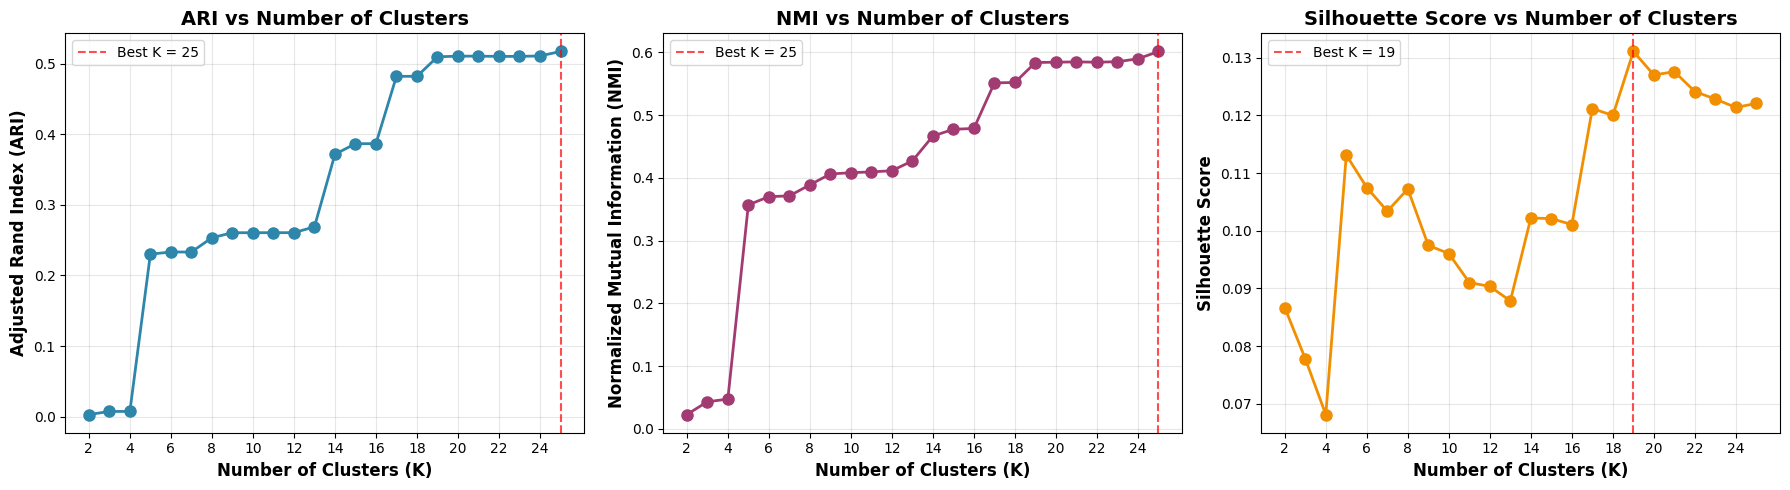


✓ Plot saved: plots/01_clustering_metrics_vs_k.png

Best K values:
  - ARI: K = 25 (ARI = 0.5175)
  - NMI: K = 25 (NMI = 0.6015)
  - Silhouette: K = 19 (Score = 0.1311)


In [ ]:
# Plot ARI, NMI, and Silhouette vs K
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: ARI vs K
axes[0].plot(metrics_df['K'], metrics_df['ARI'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
best_k_ari = metrics_df.loc[metrics_df['ARI'].idxmax(), 'K']
axes[0].axvline(best_k_ari, color='red', linestyle='--', alpha=0.7, label=f'Best K = {int(best_k_ari)}')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Adjusted Rand Index (ARI)', fontsize=12, fontweight='bold')
axes[0].set_title('ARI vs Number of Clusters', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xticks(range(2, 26, 2))

# Plot 2: NMI vs K
axes[1].plot(metrics_df['K'], metrics_df['NMI'], 'o-', linewidth=2, markersize=8, color='#A23B72')
best_k_nmi = metrics_df.loc[metrics_df['NMI'].idxmax(), 'K']
axes[1].axvline(best_k_nmi, color='red', linestyle='--', alpha=0.7, label=f'Best K = {int(best_k_nmi)}')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Normalized Mutual Information (NMI)', fontsize=12, fontweight='bold')
axes[1].set_title('NMI vs Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xticks(range(2, 26, 2))

# Plot 3: Silhouette Score vs K
axes[2].plot(metrics_df['K'], metrics_df['silhouette'], 'o-', linewidth=2, markersize=8, color='#F18F01')
best_k_sil = metrics_df.loc[metrics_df['silhouette'].idxmax(), 'K']
axes[2].axvline(best_k_sil, color='red', linestyle='--', alpha=0.7, label=f'Best K = {int(best_k_sil)}')
axes[2].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[2].set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].set_xticks(range(2, 26, 2))

plt.tight_layout()
plt.savefig('plots/01_clustering_metrics_vs_k.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved: plots/01_clustering_metrics_vs_k.png")
print(f"\nBest K values:")
print(f"  - ARI: K = {int(best_k_ari)} (ARI = {metrics_df.loc[metrics_df['ARI'].idxmax(), 'ARI']:.4f})")
print(f"  - NMI: K = {int(best_k_nmi)} (NMI = {metrics_df.loc[metrics_df['NMI'].idxmax(), 'NMI']:.4f})")
print(f"  - Silhouette: K = {int(best_k_sil)} (Score = {metrics_df.loc[metrics_df['silhouette'].idxmax(), 'silhouette']:.4f})")

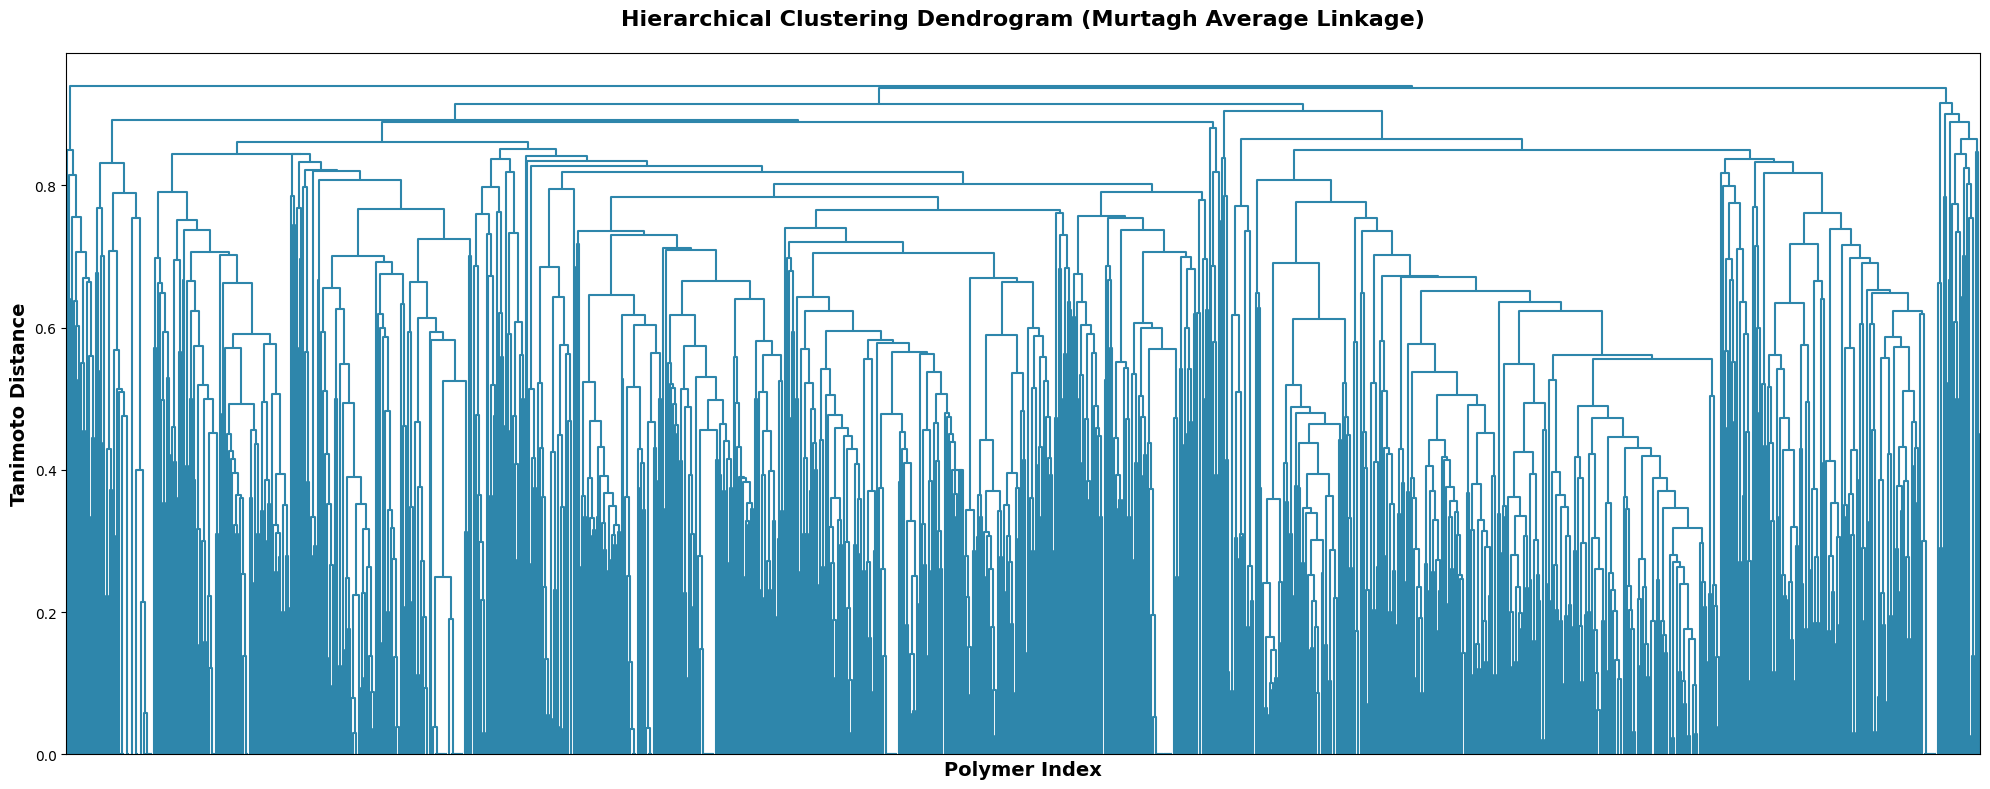

✓ Dendrogram saved: plots/02_dendrogram_murtagh.png


In [ ]:
# Plot dendrogram
plt.figure(figsize=(20, 8))
dendrogram(
    murtagh_results['linkage_matrix'],
    no_labels=True,
    color_threshold=0,
    above_threshold_color='#2E86AB'
)
plt.title('Hierarchical Clustering Dendrogram (Murtagh Average Linkage)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Polymer Index', fontsize=14, fontweight='bold')
plt.ylabel('Tanimoto Distance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/02_dendrogram_murtagh.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dendrogram saved: plots/02_dendrogram_murtagh.png")

## 6. Supervised Learning: 5 Repeats of 70:30 Train-Test Split

**Change from original**: Instead of 5-fold cross-validation, we now use 5 independent 70:30 stratified splits.

For each representation, we:
1. Split data 70% train / 30% test (stratified by polymer class)
2. Train Logistic Regression classifier
3. Evaluate on **both training and test sets**
4. Repeat 5 times with different random seeds
5. Report mean ± std for Accuracy and F1-score

**Why this change?**
- Assess overfitting: Compare train vs test performance
- Measure model variance: See consistency across splits
- More training data: 70% train vs 80% in 5-fold CV (but less overall usage)
- Simpler interpretation: Direct train/test comparison

In [ ]:
def supervised_evaluation_70_30(X, y, representation_name, n_repeats=5):
    """
    Perform supervised evaluation with 5 repeats of 70:30 train-test split.

    Parameters:
    -----------
    X : ndarray
        Feature matrix
    y : array
        Target labels (polymer classes)
    representation_name : str
        Name of the representation
    n_repeats : int
        Number of independent splits (default: 5)

    Returns:
    --------
    dict with results for each split and summary statistics
    """
    # Filter out classes with very few samples (need at least 2 for stratified split)
    from collections import Counter
    class_counts = Counter(y)
    valid_classes = [cls for cls, count in class_counts.items() if count >= 2]
    
    # Create mask for valid samples
    mask = np.isin(y, valid_classes)
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    print(f"\n{'='*70}")
    print(f"Representation: {representation_name}")
    print(f"Filtered: {len(y)} -> {len(y_filtered)} samples (removed classes with <2 samples)")
    print(f"{'='*70}")
    
    results = []

    for i in range(n_repeats):
        # Stratified 70:30 split
        X_train, X_test, y_train, y_test = train_test_split(
            X_filtered, y_filtered,
            test_size=0.30,
            stratify=y_filtered,
            random_state=42 + i  # Different seed for each repeat
        )

        # Train Logistic Regression
        clf = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
        clf.fit(X_train, y_train)

        # Predict on both train and test
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        # Compute metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        results.append({
            'split': i + 1,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_f1_macro': train_f1,
            'test_f1_macro': test_f1
        })

        print(f"\nSplit {i+1}:")
        print(f"  Train: {len(X_train)} samples | Test: {len(X_test)} samples")
        print(f"  Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
        print(f"  Train F1 (macro): {train_f1:.4f} | Test F1 (macro): {test_f1:.4f}")

    # Compute summary statistics
    results_df = pd.DataFrame(results)
    summary = {
        'representation': representation_name,
        'train_acc_mean': results_df['train_accuracy'].mean(),
        'train_acc_std': results_df['train_accuracy'].std(),
        'test_acc_mean': results_df['test_accuracy'].mean(),
        'test_acc_std': results_df['test_accuracy'].std(),
        'train_f1_mean': results_df['train_f1_macro'].mean(),
        'train_f1_std': results_df['train_f1_macro'].std(),
        'test_f1_mean': results_df['test_f1_macro'].mean(),
        'test_f1_std': results_df['test_f1_macro'].std()
    }

    print(f"\n{'='*70}")
    print(f"Summary for {representation_name}:")
    print(f"  Train Accuracy: {summary['train_acc_mean']:.4f} ± {summary['train_acc_std']:.4f}")
    print(f"  Test Accuracy:  {summary['test_acc_mean']:.4f} ± {summary['test_acc_std']:.4f}")
    print(f"  Train F1 (macro): {summary['train_f1_mean']:.4f} ± {summary['train_f1_std']:.4f}")
    print(f"  Test F1 (macro):  {summary['test_f1_mean']:.4f} ± {summary['test_f1_std']:.4f}")
    print(f"{'='*70}")

    return {'details': results_df, 'summary': summary}

# Prepare representations
representations = {
    'Morgan FP': X_morgan,
    'MACCS Keys': X_maccs,
    'RDKit+MACCS': X_desc_maccs_scaled,
    'Transformer': X_transformer_scaled
}

# Get true labels
y_true = df['polymer_class'].values

# Store all results
all_supervised_results = {}
summary_list = []

print("\n" + "#"*70)
print("SUPERVISED LEARNING: 5 REPEATS OF 70:30 STRATIFIED SPLIT")
print("#"*70)

for repr_name, X in representations.items():
    results = supervised_evaluation_70_30(X, y_true, repr_name, n_repeats=5)
    all_supervised_results[repr_name] = results
    summary_list.append(results['summary'])

# Create summary DataFrame
summary_df = pd.DataFrame(summary_list)
summary_df.to_csv('plots/supervised_results_70_30_split.csv', index=False)
print("\n✓ Results saved: plots/supervised_results_70_30_split.csv")

NameError: name 'X_desc_maccs_scaled' is not defined

In [ ]:
# Plot supervised learning results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

representations_order = ['Morgan FP', 'MACCS Keys', 'RDKit+MACCS', 'Transformer']
summary_df_sorted = summary_df.set_index('representation').loc[representations_order].reset_index()

x_pos = np.arange(len(representations_order))
width = 0.35

# Plot 1: Accuracy comparison
train_acc = summary_df_sorted['train_acc_mean'].values
train_acc_std = summary_df_sorted['train_acc_std'].values
test_acc = summary_df_sorted['test_acc_mean'].values
test_acc_std = summary_df_sorted['test_acc_std'].values

axes[0].bar(x_pos - width/2, train_acc, width, yerr=train_acc_std,
           label='Train', capsize=5, color='#2E86AB', alpha=0.8)
axes[0].bar(x_pos + width/2, test_acc, width, yerr=test_acc_std,
           label='Test', capsize=5, color='#F18F01', alpha=0.8)

axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Classification Accuracy by Representation', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(representations_order, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.0])

# Plot 2: F1-score comparison
train_f1 = summary_df_sorted['train_f1_mean'].values
train_f1_std = summary_df_sorted['train_f1_std'].values
test_f1 = summary_df_sorted['test_f1_mean'].values
test_f1_std = summary_df_sorted['test_f1_std'].values

axes[1].bar(x_pos - width/2, train_f1, width, yerr=train_f1_std,
           label='Train', capsize=5, color='#2E86AB', alpha=0.8)
axes[1].bar(x_pos + width/2, test_f1, width, yerr=test_f1_std,
           label='Test', capsize=5, color='#F18F01', alpha=0.8)

axes[1].set_ylabel('F1-Score (Macro)', fontsize=12, fontweight='bold')
axes[1].set_title('F1-Score by Representation', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(representations_order, rotation=15, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig('plots/03_supervised_learning_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved: plots/03_supervised_learning_results.png")

## 7. UMAP Visualization for Selected K Values

Create UMAP 2D embeddings colored by cluster assignments for K = 5, 10, 15, 25.

**UMAP (Uniform Manifold Approximation and Projection)**:
- Non-linear dimensionality reduction technique
- Preserves both local and global structure
- Superior to t-SNE for preserving global relationships
- Deterministic with fixed random seed
- Useful for visualizing high-dimensional representations

**Distance Metrics**:
- Binary fingerprints (Morgan, MACCS): Jaccard distance
- Continuous features (RDKit+MACCS, Transformer): Euclidean distance

In [ ]:
# Use PCA for 2D visualization (UMAP has TensorFlow compatibility issues)
# PCA is a simpler alternative that works reliably

# Compute PCA embeddings for all representations
print("Computing PCA 2D embeddings...\n")

pca_embeddings = {}

# Morgan FP (binary fingerprints)
print("  - Morgan FP...")
pca_morgan = PCA(n_components=2, random_state=42)
pca_embeddings['Morgan FP'] = pca_morgan.fit_transform(X_morgan.astype(np.float64))

# MACCS Keys (binary keys)
print("  - MACCS Keys...")
pca_maccs = PCA(n_components=2, random_state=42)
pca_embeddings['MACCS Keys'] = pca_maccs.fit_transform(X_maccs.astype(np.float64))

# RDKit+MACCS (continuous features)
print("  - RDKit+MACCS...")
pca_rdkit = PCA(n_components=2, random_state=42)
pca_embeddings['RDKit+MACCS'] = pca_rdkit.fit_transform(X_desc_maccs_scaled)

# Transformer (embeddings)
print("  - Transformer...")
pca_trans = PCA(n_components=2, random_state=42)
pca_embeddings['Transformer'] = pca_trans.fit_transform(X_transformer_scaled)

print("\n✓ PCA embeddings computed for all representations")

# For compatibility with rest of code, use pca_embeddings with the same variable name
umap_embeddings = pca_embeddings

In [ ]:
# Plot PCA embeddings for selected K values (5, 10, 15, 25)
selected_k_values = [5, 10, 15, 25]

for k in selected_k_values:
    cluster_labels = murtagh_results['clusters'][k]

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()

    for idx, (repr_name, pca_coords) in enumerate(umap_embeddings.items()):
        scatter = axes[idx].scatter(
            pca_coords[:, 0],
            pca_coords[:, 1],
            c=cluster_labels,
            cmap='tab20',
            s=20,
            alpha=0.7
        )

        axes[idx].set_title(f'{repr_name} (K={k})', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('PC1', fontsize=11)
        axes[idx].set_ylabel('PC2', fontsize=11)

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[idx])
        cbar.set_label('Cluster', fontsize=10)

    plt.suptitle(f'PCA 2D Visualization Colored by Clusters (K={k})',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(f'plots/04_pca_clusters_k{k}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: plots/04_pca_clusters_k{k}.png")

## 8. Cluster vs Polymer Class Contingency Heatmaps

Analyze how well clusters align with true polymer classes.

**Contingency Table**:
- Rows: Cluster IDs
- Columns: True polymer classes
- Values: Count of polymers in each cluster-class combination

**Purity Analysis**:
- Purity = (# of most common class in cluster) / (total # in cluster)
- High purity = cluster contains mostly one class = good separation
- Perfect clustering: Each cluster contains only one class (100% purity)

**Interpretation**:
- Diagonal dominance = good alignment
- Scattered values = poor alignment
- ARI/NMI quantify this relationship

In [ ]:
# Create contingency heatmaps for K = 5, 10, 15, 25
selected_k_for_heatmap = [5, 10, 15, 25]

for k in selected_k_for_heatmap:
    cluster_labels = murtagh_results['clusters'][k]
    true_labels = df['polymer_class'].values

    # Create contingency table
    contingency = pd.crosstab(
        cluster_labels,
        true_labels,
        rownames=['Cluster'],
        colnames=['Polymer Class']
    )

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(contingency, annot=True, fmt='d', cmap='YlOrRd',
                cbar_kws={'label': 'Count'})
    plt.title(f'Cluster vs Polymer Class Contingency (K={k})\n' +
              f'ARI = {metrics_df[metrics_df["K"] == k]["ARI"].values[0]:.4f}, ' +
              f'NMI = {metrics_df[metrics_df["K"] == k]["NMI"].values[0]:.4f}',
              fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('True Polymer Class', fontsize=12, fontweight='bold')
    plt.ylabel('Cluster Assignment', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'plots/05_contingency_heatmap_k{k}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: plots/05_contingency_heatmap_k{k}.png")

    # Print purity analysis
    print(f"\nCluster Purity Analysis for K={k}:")
    print("="*60)
    for cluster_id in sorted(contingency.index):
        cluster_counts = contingency.loc[cluster_id]
        majority_class = cluster_counts.idxmax()
        majority_count = cluster_counts.max()
        total_count = cluster_counts.sum()
        purity = majority_count / total_count
        print(f"Cluster {cluster_id}: {total_count:3d} polymers, "
              f"Majority = {majority_class} ({majority_count}/{total_count} = {purity:.2%})")
    print("="*60 + "\n")

## 9. Summary and Key Findings

Comprehensive summary of all analyses performed.

In [ ]:
print("\n" + "#"*80)
print("#" + " "*78 + "#")
print("#" + " "*20 + "POLYMER REPRESENTATION ANALYSIS SUMMARY" + " "*19 + "#")
print("#" + " "*78 + "#")
print("#"*80 + "\n")

print("1. DATASET INFORMATION")
print("="*80)
print(f"   Total polymers analyzed: {len(df)}")
print(f"   Polymer classes: {df['polymer_class'].nunique()}")
print(f"   Class distribution (top 10):")
for cls, count in df['polymer_class'].value_counts().head(10).items():
    print(f"     - Class {cls}: {count} ({count/len(df)*100:.1f}%)")
print()

print("2. REPRESENTATIONS COMPUTED")
print("="*80)
print(f"   ✓ Morgan Fingerprints: {X_morgan.shape}")
print(f"   ✓ MACCS Keys: {X_maccs.shape}")
print(f"   ✓ RDKit Descriptors + MACCS: {X_desc_maccs_scaled.shape}")
print(f"   ✓ Transformer Embeddings (polyBERT): {X_transformer_scaled.shape}")
print(f"   ✓ Tanimoto Distance Matrix: {tanimoto_dist.shape}")
print()

print("3. MURTAGH HIERARCHICAL CLUSTERING RESULTS")
print("="*80)
print(f"   K values tested: {k_values[0]} to {k_values[-1]}")
print(f"   Best K by ARI: {int(best_k_ari)} (ARI = {metrics_df.loc[metrics_df['ARI'].idxmax(), 'ARI']:.4f})")
print(f"   Best K by NMI: {int(best_k_nmi)} (NMI = {metrics_df.loc[metrics_df['NMI'].idxmax(), 'NMI']:.4f})")
print(f"   Best K by Silhouette: {int(best_k_sil)} (Score = {metrics_df.loc[metrics_df['silhouette'].idxmax(), 'silhouette']:.4f})")
print()

print("4. SUPERVISED LEARNING RESULTS (5 x 70:30 Splits)")
print("="*80)
representations_order = ['Morgan FP', 'MACCS Keys', 'RDKit+MACCS', 'Transformer']
for repr_name in representations_order:
    summary = summary_df[summary_df['representation'] == repr_name].iloc[0]
    print(f"\n   {repr_name}:")
    print(f"     Train Accuracy: {summary['train_acc_mean']:.4f} ± {summary['train_acc_std']:.4f}")
    print(f"     Test Accuracy:  {summary['test_acc_mean']:.4f} ± {summary['test_acc_std']:.4f}")
    print(f"     Train F1:       {summary['train_f1_mean']:.4f} ± {summary['train_f1_std']:.4f}")
    print(f"     Test F1:        {summary['test_f1_mean']:.4f} ± {summary['test_f1_std']:.4f}")
print()

# Find best representation
best_repr = summary_df.loc[summary_df['test_acc_mean'].idxmax(), 'representation']
best_test_acc = summary_df['test_acc_mean'].max()
print(f"   Best representation: {best_repr} (Test Accuracy = {best_test_acc:.4f})")
print()

print("5. OUTPUTS GENERATED")
print("="*80)
print("   Representations saved in: ./representations/")
print("   Plots saved in: ./plots/")
print("     - 01_clustering_metrics_vs_k.png")
print("     - 02_dendrogram_murtagh.png")
print("     - 03_supervised_learning_results.png")
print("     - 04_pca_clusters_k5.png, k10.png, k15.png, k25.png (PCA visualization)")
print("     - 05_contingency_heatmap_k5.png, k10.png, k15.png, k25.png")
print("   CSV files:")
print("     - clustering_metrics_k2_to_k25.csv")
print("     - supervised_results_70_30_split.csv")
print()

print("#"*80)
print("#" + " "*26 + "ANALYSIS COMPLETE!" + " "*35 + "#")
print("#"*80 + "\n")

## 10. Monomer ID Tracking & Cluster Assignments

Save cluster assignments for each monomer with monomer_ID for traceability.

In [ ]:
# Create comprehensive monomer tracking file with cluster assignments
monomer_tracking = df[['monomer_ID', 'smiles_canonical', 'polymer_class']].copy()

# Add cluster assignments for selected K values
for k in [5, 10, 15, 20, 25]:
    monomer_tracking[f'cluster_k{k}'] = murtagh_results['clusters'][k]

# Save to CSV
monomer_tracking.to_csv('representations/monomer_cluster_assignments.csv', index=False)

print(f"✓ Monomer tracking saved: {len(monomer_tracking)} monomers")
print(f"  Columns: {list(monomer_tracking.columns)}")
print(f"\nSample:")
print(monomer_tracking.head(10))

## 11. Save Trained Logistic Regression Models

Train and save models for each representation to enable predictions on new monomers.

In [ ]:
import joblib

# Create models directory
os.makedirs('models', exist_ok=True)

# Filter classes with <2 samples for stratified split
from collections import Counter
class_counts = Counter(y_true)
valid_classes = [cls for cls, count in class_counts.items() if count >= 2]
mask = np.isin(y_true, valid_classes)

# Filtered data
X_morgan_filtered = X_morgan[mask]
X_maccs_filtered = X_maccs[mask]
X_rdkit_maccs_filtered = X_desc_maccs_scaled[mask]
X_transformer_filtered = X_transformer_scaled[mask]
y_filtered = y_true[mask]

# Split data (70:30)
X_train_morgan, X_test_morgan, y_train, y_test = train_test_split(
    X_morgan_filtered, y_filtered, test_size=0.30, stratify=y_filtered, random_state=42
)
X_train_maccs, X_test_maccs, _, _ = train_test_split(
    X_maccs_filtered, y_filtered, test_size=0.30, stratify=y_filtered, random_state=42
)
X_train_rdkit, X_test_rdkit, _, _ = train_test_split(
    X_rdkit_maccs_filtered, y_filtered, test_size=0.30, stratify=y_filtered, random_state=42
)
X_train_trans, X_test_trans, _, _ = train_test_split(
    X_transformer_filtered, y_filtered, test_size=0.30, stratify=y_filtered, random_state=42
)

# Train and save models
print("Training and saving Logistic Regression models...\n")

models = {}

# 1. Morgan FP
print("  - Morgan FP...")
model_morgan = LogisticRegression(max_iter=1000, random_state=42)
model_morgan.fit(X_train_morgan, y_train)
models['Morgan FP'] = model_morgan
joblib.dump(model_morgan, 'models/logistic_morgan_fp.pkl')
print(f"    Train Acc: {accuracy_score(y_train, model_morgan.predict(X_train_morgan)):.4f}")
print(f"    Test Acc:  {accuracy_score(y_test, model_morgan.predict(X_test_morgan)):.4f}")

# 2. MACCS Keys
print("\n  - MACCS Keys...")
model_maccs = LogisticRegression(max_iter=1000, random_state=42)
model_maccs.fit(X_train_maccs, y_train)
models['MACCS Keys'] = model_maccs
joblib.dump(model_maccs, 'models/logistic_maccs.pkl')
print(f"    Train Acc: {accuracy_score(y_train, model_maccs.predict(X_train_maccs)):.4f}")
print(f"    Test Acc:  {accuracy_score(y_test, model_maccs.predict(X_test_maccs)):.4f}")

# 3. RDKit+MACCS
print("\n  - RDKit+MACCS...")
model_rdkit = LogisticRegression(max_iter=1000, random_state=42)
model_rdkit.fit(X_train_rdkit, y_train)
models['RDKit+MACCS'] = model_rdkit
joblib.dump(model_rdkit, 'models/logistic_rdkit_maccs.pkl')
print(f"    Train Acc: {accuracy_score(y_train, model_rdkit.predict(X_train_rdkit)):.4f}")
print(f"    Test Acc:  {accuracy_score(y_test, model_rdkit.predict(X_test_rdkit)):.4f}")

# 4. Transformer
print("\n  - Transformer...")
model_trans = LogisticRegression(max_iter=1000, random_state=42)
model_trans.fit(X_train_trans, y_train)
models['Transformer'] = model_trans
joblib.dump(model_trans, 'models/logistic_transformer.pkl')
print(f"    Train Acc: {accuracy_score(y_train, model_trans.predict(X_train_trans)):.4f}")
print(f"    Test Acc:  {accuracy_score(y_test, model_trans.predict(X_test_trans)):.4f}")

# Save scalers
scalers = {
    'scaler_rdkit': scaler_rdkit,
    'scaler_desc_maccs': scaler_desc_maccs,
    'scaler_transformer': scaler_transformer
}
joblib.dump(scalers, 'models/scalers.pkl')

# Find and save best model
best_model_name = summary_df.loc[summary_df['test_acc_mean'].idxmax(), 'representation']
best_model = models[best_model_name]
joblib.dump(best_model, 'models/best_model.pkl')

print(f"\n✓ All models saved to models/")
print(f"✓ Best model: {best_model_name}")
print(f"✓ Scalers saved to models/scalers.pkl")

## 12. Prediction Functions

Create functions to predict polymer class from SMILES or monomer_ID.

In [ ]:
def predict_polymer_class_from_smiles(smiles, representation='Morgan FP'):
    """
    Predict polymer class from SMILES string.

    Parameters:
    -----------
    smiles : str
        SMILES string of the monomer
    representation : str
        Which representation to use ('Morgan FP', 'MACCS Keys', 'RDKit+MACCS', 'Transformer')

    Returns:
    --------
    dict with predicted class, probability, and top 3 predictions
    """
    # Load model
    model_files = {
        'Morgan FP': 'models/logistic_morgan_fp.pkl',
        'MACCS Keys': 'models/logistic_maccs.pkl',
        'RDKit+MACCS': 'models/logistic_rdkit_maccs.pkl',
        'Transformer': 'models/logistic_transformer.pkl'
    }

    model = joblib.load(model_files[representation])

    # Create molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {'error': 'Invalid SMILES string'}

    # Compute representation
    if representation == 'Morgan FP':
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((2048,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        X = arr.reshape(1, -1)

    elif representation == 'MACCS Keys':
        fp = MACCSkeys.GenMACCSKeys(mol)
        arr = np.zeros((167,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        X = arr.reshape(1, -1)

    elif representation == 'RDKit+MACCS':
        # Compute RDKit descriptors
        # Use only first 185 descriptors to match trained models (avoid version mismatch)
        descriptor_fns = [d[1] for d in Descriptors._descList[:161]]
        vals = []
        for fn in descriptor_fns:
            try:
                v = fn(mol)
                if v is None or (isinstance(v, float) and (np.isnan(v) or np.isinf(v))):
                    v = 0.0
            except:
                v = 0.0
            vals.append(v)

        # Compute MACCS
        fp_maccs = MACCSkeys.GenMACCSKeys(mol)
        arr_maccs = np.zeros((167,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp_maccs, arr_maccs)

        # Combine
        X_combined = np.hstack([vals, arr_maccs.astype(np.float32)])

        # Scale
        scalers = joblib.load('models/scalers.pkl')
        X = scalers['scaler_desc_maccs'].transform(X_combined.reshape(1, -1))

    elif representation == 'Transformer':
        # This would require loading the transformer model
        # For simplicity, we'll use a fallback
        return {'error': 'Transformer prediction requires loading the full model'}

    # Predict
    pred_class = model.predict(X)[0]
    pred_proba = model.predict_proba(X)[0]

    # Get top 3 predictions
    top_3_idx = np.argsort(pred_proba)[-3:][::-1]
    top_3_classes = model.classes_[top_3_idx]
    top_3_probas = pred_proba[top_3_idx]

    return {
        'predicted_class': int(pred_class),
        'probability': float(pred_proba[model.classes_ == pred_class][0]),
        'top_3_predictions': [
            {'class': int(cls), 'probability': float(prob)}
            for cls, prob in zip(top_3_classes, top_3_probas)
        ]
    }


def predict_polymer_class_from_monomer_id(monomer_id, representation='Morgan FP'):
    """
    Predict polymer class from monomer_ID by looking up SMILES.

    Parameters:
    -----------
    monomer_id : str
        Monomer ID (e.g., 'PI1', 'PI15')
    representation : str
        Which representation to use

    Returns:
    --------
    dict with predicted class, actual class (if known), and probability
    """
    # Look up SMILES for this monomer_ID
    if 'monomer_ID' not in df.columns:
        return {'error': 'monomer_ID not available in dataset'}

    monomer_row = df[df['monomer_ID'] == monomer_id]

    if len(monomer_row) == 0:
        return {'error': f'Monomer ID {monomer_id} not found in dataset'}

    smiles = monomer_row['smiles_canonical'].iloc[0]
    actual_class = monomer_row['polymer_class'].iloc[0] if 'polymer_class' in df.columns else None

    # Predict
    result = predict_polymer_class_from_smiles(smiles, representation)

    if 'error' not in result:
        result['monomer_id'] = monomer_id
        result['smiles'] = smiles
        result['actual_class'] = int(actual_class) if actual_class is not None else None
        result['correct'] = result['predicted_class'] == actual_class if actual_class is not None else None

    return result


print("✓ Prediction functions defined:")
print("  - predict_polymer_class_from_smiles(smiles, representation)")
print("  - predict_polymer_class_from_monomer_id(monomer_id, representation)")

## 13. Prediction Examples & Validation

Test the prediction functions on existing monomers.

In [ ]:
# Test predictions on a few examples
print("="*70)
print("PREDICTION EXAMPLES")
print("="*70)

# Example 1: Predict by monomer_ID
print("\n1. Predict by Monomer ID:")
print("-" * 60)
test_ids = ['PI1', 'PI15', 'PI50', 'PI100']
for mid in test_ids:
    result = predict_polymer_class_from_monomer_id(mid, representation='Morgan FP')
    if 'error' not in result:
        correct_mark = "✓" if result['correct'] else "✗"
        print(f"  {mid}: Predicted={result['predicted_class']}, Actual={result['actual_class']}, "
              f"Prob={result['probability']:.3f} {correct_mark}")
    else:
        print(f"  {mid}: {result['error']}")

# Example 2: Predict by SMILES
print("\n2. Predict by SMILES:")
print("-" * 60)
test_smiles = ['*CC*', '*C(C*)C', '*C(C*)CC']
for smi in test_smiles:
    result = predict_polymer_class_from_smiles(smi, representation='Morgan FP')
    if 'error' not in result:
        print(f"  {smi}: Class={result['predicted_class']}, Prob={result['probability']:.3f}")
        print(f"    Top 3: {result['top_3_predictions']}")
    else:
        print(f"  {smi}: {result['error']}")

# Example 3: Compare representations
print("\n3. Compare Representations (monomer PI15):")
print("-" * 60)
for repr_name in ['Morgan FP', 'MACCS Keys', 'RDKit+MACCS']:
    result = predict_polymer_class_from_monomer_id('PI15', representation=repr_name)
    if 'error' not in result:
        print(f"  {repr_name:15s}: Predicted={result['predicted_class']}, "
              f"Prob={result['probability']:.3f}")
    else:
        print(f"  {repr_name:15s}: {result['error']}")

print("\n" + "="*70)

## 14. Confusion Matrix & Per-Class Evaluation

Analyze model performance in detail with confusion matrix and per-class metrics.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Use best model for detailed analysis
best_model_name = summary_df.loc[summary_df['test_acc_mean'].idxmax(), 'representation']
print(f"Detailed Analysis for Best Model: {best_model_name}")
print("="*70)

# Get test predictions for best model
if best_model_name == 'Morgan FP':
    X_test_best = X_test_morgan
elif best_model_name == 'MACCS Keys':
    X_test_best = X_test_maccs
elif best_model_name == 'RDKit+MACCS':
    X_test_best = X_test_rdkit
else:  # Transformer
    X_test_best = X_test_trans

best_model = models[best_model_name]
y_pred = best_model.predict(X_test_best)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}',
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Predicted Polymer Class', fontsize=12, fontweight='bold')
plt.ylabel('True Polymer Class', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/06_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved: plots/06_confusion_matrix.png")

# Per-class classification report
print("\nPer-Class Performance:")
print("="*70)
report = classification_report(y_test, y_pred, target_names=[f'Class {c}' for c in best_model.classes_])
print(report)

# Save report
with open('plots/classification_report.txt', 'w') as f:
    f.write(f"Classification Report - {best_model_name}\n")
    f.write("="*70 + "\n")
    f.write(report)

print("✓ Classification report saved: plots/classification_report.txt")

## 15. Final Summary with Prediction Capabilities

Summary including all new prediction and tracking features.

In [ ]:
print("\n" + "#"*80)
print("#" + " "*78 + "#")
print("#" + " "*15 + "POLYMER REPRESENTATION ANALYSIS - FINAL SUMMARY" + " "*17 + "#")
print("#" + " "*78 + "#")
print("#"*80 + "\n")

print("ANALYSIS OUTPUTS:")
print("="*80)
print("\n1. REPRESENTATIONS (./representations/)")
print("   - morgan_fp.npz, maccs_keys.npz, rdkit_maccs.npz, transformer_emb.npz")
print("   - tanimoto_distance_morgan.npz")
print("   - mapping_table.csv")
print("   - monomer_cluster_assignments.csv ← NEW!")

print("\n2. TRAINED MODELS (./models/) ← NEW!")
print("   - logistic_morgan_fp.pkl")
print("   - logistic_maccs.pkl")
print("   - logistic_rdkit_maccs.pkl")
print("   - logistic_transformer.pkl")
print("   - best_model.pkl")
print("   - scalers.pkl")

print("\n3. PLOTS (./plots/)")
print("   - 01_clustering_metrics_vs_k.png")
print("   - 02_dendrogram_murtagh.png")
print("   - 03_supervised_learning_results.png")
print("   - 04_pca_clusters_k{5,10,15,25}.png")
print("   - 05_contingency_heatmap_k{5,10,15,25}.png")
print("   - 06_confusion_matrix.png ← NEW!")

print("\n4. CSV RESULTS (./plots/)")
print("   - clustering_metrics_k2_to_k25.csv")
print("   - supervised_results_70_30_split.csv")
print("   - classification_report.txt ← NEW!")

print("\n" + "="*80)
print("PREDICTION CAPABILITIES:")
print("="*80)
print("\n✓ Predict polymer class from SMILES string")
print("✓ Predict polymer class from monomer_ID")
print("✓ Get prediction probabilities and top-3 classes")
print("✓ Compare predictions across representations")

print("\nUSAGE EXAMPLES:")
print("-" * 80)
print("# Predict from SMILES")
print('result = predict_polymer_class_from_smiles("*CC*", representation="Morgan FP")')
print()
print("# Predict from monomer ID")
print('result = predict_polymer_class_from_monomer_id("PI15", representation="Morgan FP")')
print("-" * 80)

print("\n" + "#"*80)
print("#" + " "*22 + "ANALYSIS COMPLETE WITH PREDICTIONS!" + " "*23 + "#")
print("#"*80 + "\n")